# Imports

In [4]:
from multisensory_playbook import (
    ClassicalTask,
    DetectionTask,
    DetectionTask_versatile,
    LinearClassifier,
    Trials
)
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
import joblib
root = Path("./data/")

# Hyperparameters

In [5]:
# "s_range": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Sparse to Dense, sparse is less than 0.2
def calc_pe(pe_precursor, k):
    """
    Calculate effective pe, given an input pe and on-length k
    """
    pe = 1 - ((1 - pe_precursor) ** k)
    return pe

def calc_precursor_pe(pe, k):
    """
    Calculate pe, given an effective pe and on-length k
    """
    precursor_pe= 1 - ((1-pe)**(1/k))
    return precursor_pe

def calculate_pg(ff, k, N=90, correction=1):
    """
    Use ff to calulate pg, given a k and N
    ff: desired filtered fraction of E 
    pg: probability of E(t)=1 in the base_e (generator)
    k : local on-time duration
    N : number time-steps
    """
    buffer = k
    #pg = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N)), 0.9))[0] 
    if correction:
        ff = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N+int(buffer)-1*(k-1))), 0.9))[0]

    return ff
    
# Tasks
# Detection task, old formulation
pe_dense = 0.3
pe_sparse = 0.04
nb_steps = 500 
# Detection task, new versatile formulation
time_dep = 1 # 1: there is time dependence
#k = 3 # if e_t=1, then e_(t+1)=1 and e_(t+2)=1

pm=1
pc = 0.1 #0.45
pn = 0.9# 1/3
"""
task_keys = []
for kk in range(1,9):
    #task_keys.append(f"Dense Det_{kk}")
    task_keys.append(f"Sparse Det_{kk}")
"""
#task_keys = ['Classical']
#save_path = root / f"ideal_data_{pe_sparse}sparse"
task_keys = ['Sparse Det_1',
 'Sparse Det_2',
 'Sparse Det_3',
 'Sparse Det_4',
 'Sparse Det_5',
 'Sparse Det_6',
 'Sparse Det_7',
 'Sparse Det_8']
tasks = [

    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+1-1, k=1), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=1), # sparse
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+2-1,k=2), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=2), # sparse  
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+3-1,k=3), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=3), # sparse
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+4-1,k=4), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=4), # sparse
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+5-1,k=5), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=5), # sparse 
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+6-1,k=6), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=6), # sparse 
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+7-1,k=7), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=7), # sparse
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+8-1,k=8), pc=pc, pn=pn, pi=0.01, time_dep=time_dep, k=8) # sparse
    
]



nb_trials = 1#000 # Original: 100000

classifier_type = LinearClassifier
# Sparsity values
sparsity = {}
#sparsity['Dense detection'] = pe_dense
#sparsity['Sparse detection'] = pe_sparse


# Analysis

In [6]:
tasks

[DetectionTask_versatile(pm=1, pe=0.039999999947525566, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=1, random_seed=None, do_return=True),
 DetectionTask_versatile(pm=1, pe=0.020203378225615576, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=2, random_seed=None, do_return=True),
 DetectionTask_versatile(pm=1, pe=0.013500464604403462, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=3, random_seed=None, do_return=True),
 DetectionTask_versatile(pm=1, pe=0.010091488720119224, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=4, random_seed=None, do_return=True),
 DetectionTask_versatile(pm=1, pe=0.00798715448292997, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=5, random_seed=None, do_return=True),
 DetectionTask_versatile(pm=1, pe=0.006530144511064928, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=6, random_seed=None, do_return=True),
 DetectionTask_versatile(pm=1, pe=0.005443341412635139, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, tim

In [28]:
ideal_dict = {}
windowsize_list = [3]
k_list = [1,2,3,4,5,6,7,8]
trials_dict = {}
modelpath = './data/'
for a, task in enumerate(tasks):
    k = k_list[a]
    print(a, k, task)

    full_trials = task.generate_trials(nb_trials, nb_steps+k-1)
    print('Trials generated') # logging

    # Generate test data separately
    
    
    trials_dict[k] = Trials(
        repeats=nb_trials,
        time_steps=nb_steps+k-1,
        M=full_trials.M,
        A=full_trials.A,
        V=full_trials.V,
        E=full_trials.E,
        task=task
    )



0 1 DetectionTask_versatile(pm=1, pe=0.039999999947525566, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=1, random_seed=None, do_return=True)
Trials generated
1 2 DetectionTask_versatile(pm=1, pe=0.020203378225615576, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=2, random_seed=None, do_return=True)
Trials generated
2 3 DetectionTask_versatile(pm=1, pe=0.013500464604403462, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=3, random_seed=None, do_return=True)
Trials generated
3 4 DetectionTask_versatile(pm=1, pe=0.010091488720119224, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=4, random_seed=None, do_return=True)
Trials generated
4 5 DetectionTask_versatile(pm=1, pe=0.00798715448292997, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=5, random_seed=None, do_return=True)
Trials generated
5 6 DetectionTask_versatile(pm=1, pe=0.006530144511064928, pn=0.9, pc=0.1, pi=0.01, trans_prob=None, time_dep=1, k=6, random_seed=None, do_return=True)
Tria

In [8]:
print(correct_distribution_A)
print(incorrect_distribution_A)

NameError: name 'correct_distribution_A' is not defined

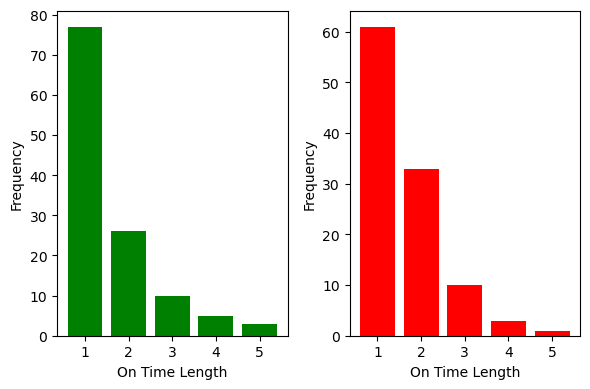

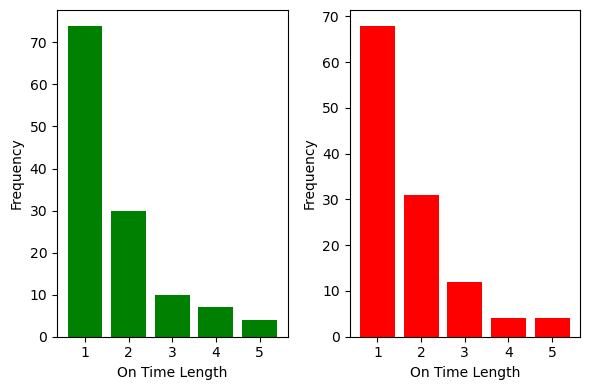

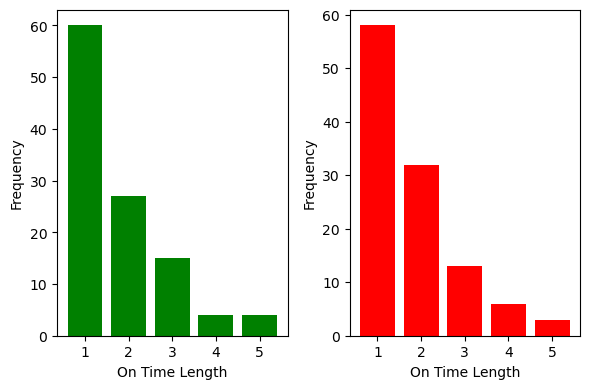

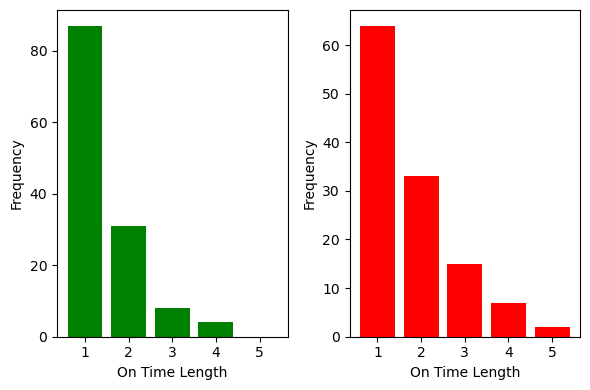

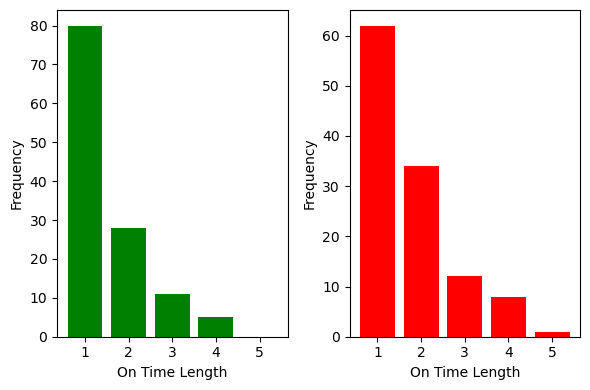

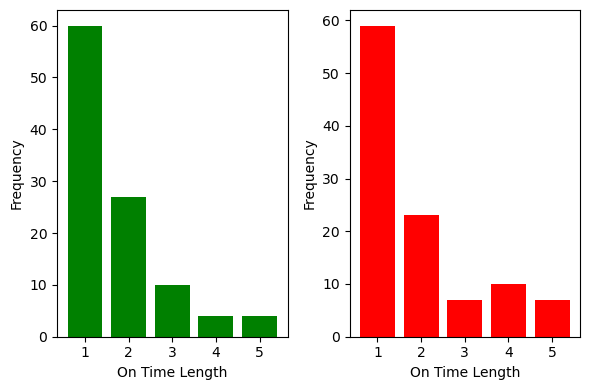

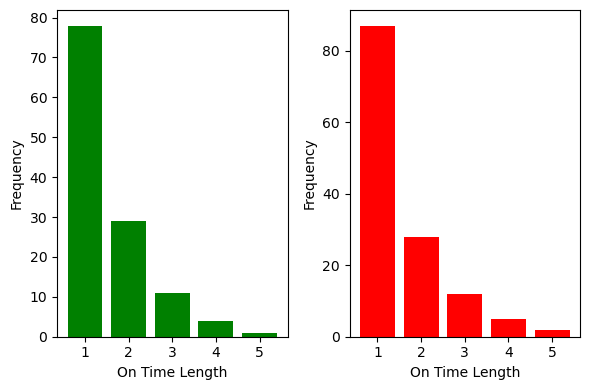

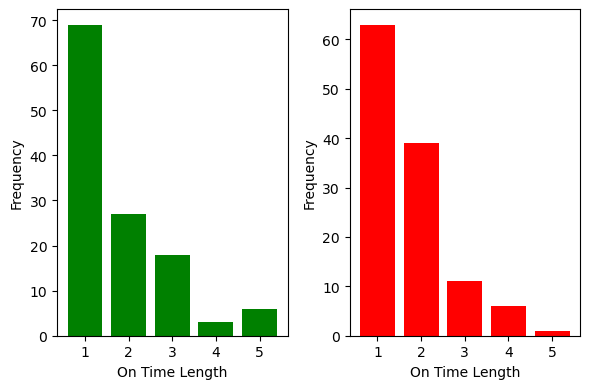

In [9]:
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def calculate_on_times(time_series, M):
    correct_on_times = []
    incorrect_on_times = []
    current_value = 0
    current_count = 0


    for value in time_series:
        if value != 0:
            if value == current_value:
                current_count += 1
            else:
                if current_value == M:
                    correct_on_times.append(current_count)
                elif current_value == -M:
                    incorrect_on_times.append(current_count)
                current_value = value
                current_count = 1
        else:
            if current_value != 0:
                if current_value == M:
                    correct_on_times.append(current_count)
                elif current_value == -M:
                    incorrect_on_times.append(current_count)
                current_value = 0
                current_count = 0

    if current_value == M:
        correct_on_times.append(current_count)
    elif current_value == -M:
        incorrect_on_times.append(current_count)
    #print(correct_on_times)
    
    return Counter(correct_on_times), Counter(incorrect_on_times)

def histplot(correct_distribution,incorrect_distribution, xticks=list(range(1, 6))):

    fig, axes = plt.subplots(1, 2, figsize=(6, 1 * 4))
    ax_correct = axes[0]
    ax_incorrect = axes[1]
    
    # Ensuring all specified xticks are included in the plot
    correct_values = [correct_distribution.get(x, 0) for x in xticks]
    incorrect_values = [incorrect_distribution.get(x, 0) for x in xticks]

    ax_correct.bar(xticks, correct_values, color='g')
    #ax_correct.set_title(f'k {i + 1}: Correct On Times (M={M})')
    ax_correct.set_xlabel('On Time Length')
    ax_correct.set_ylabel('Frequency')
    ax_correct.set_xticks(xticks)
    #ax_correct.set_ylim(top=30)
    
    ax_incorrect.bar(xticks, incorrect_values, color='r')
    #ax_incorrect.set_title(f'k {i + 1}: Incorrect On Times (M={M})')
    ax_incorrect.set_xlabel('On Time Length')
    ax_incorrect.set_ylabel('Frequency')
    ax_incorrect.set_xticks(xticks)
    #ax_incorrect.set_ylim(top=30)
    plt.tight_layout()
    plt.show()


# Specify the xticks
#xticks = list(range(1, 6))

for i, k in enumerate(k_list):
    trials = trials_dict[k]
    
    for trial in range(nb_trials):
        A = trials.A[trial].squeeze()
        V = trials.V[trial].squeeze()
        M = trials.M[trial].squeeze()
        
        corr_A, incorr_A = calculate_on_times(A, M)
        corr_V, incorr_V = calculate_on_times(V, M)
        
        if trial == 0:
            correct_distribution_A , incorrect_distribution_A = corr_A, incorr_A
            correct_distribution_V , incorrect_distribution_V = corr_V, incorr_V
        else:
            correct_distribution_A, incorrect_distribution_A = correct_distribution_A + corr_A, incorrect_distribution_A + incorr_A
            correct_distribution_V, incorrect_distribution_V = correct_distribution_V + corr_V, incorrect_distribution_V + incorr_V
            
    #num_sets = len(k_list)
    #fig, axes = plt.subplots(num_sets, 2, figsize=(10, num_sets * 5))
           
    histplot(correct_distribution_A,incorrect_distribution_A, xticks=list(range(1, 6)));
    #histplot(correct_distribution_V,incorrect_distribution_V, M=M, xticks=list(range(1, 6)));

In [10]:
trials_dict[8].M

array([-1])

In [11]:
trials_dict[6].E.squeeze()[-1]

0

In [12]:
trials_dict[k].E.squeeze()[1].shape

()

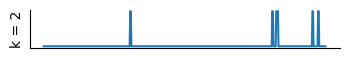

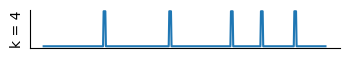

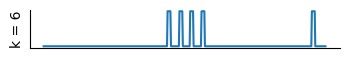

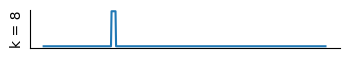

In [17]:
k_list_red = [2,4,6,8]
for k in k_list_red:
    plt.figure(figsize=(4,0.5))
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.yticks([])
    
    plt.ylabel(f"k = {k}", rotation=90)
    plt.plot(trials_dict[k].E.squeeze());
    plt.xticks([])
#plt.show()
plt.savefig('ksteps.png', dpi=500, format='png')

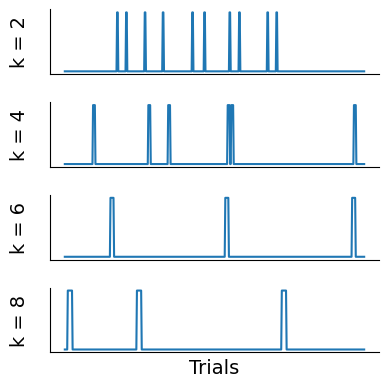

In [31]:
import matplotlib.pyplot as plt

k_list_red = [2, 4, 6, 8]
fig, axs = plt.subplots(len(k_list_red), 1, figsize=(4, 4), sharex=True)
fig.tight_layout(pad=1.0)

for idx, k in enumerate(k_list_red):
    ax = axs[idx]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([])
    ax.set_ylabel(f"k = {k}", rotation=90, fontsize=14, labelpad=15)
    ax.plot(trials_dict[k].E.squeeze())
    
    if idx != len(k_list_red) - 1:  # Hide x-axis for all but the last subplot
        ax.set_xticks([])
    else:
        ax.set_xlabel('Trials', fontsize=14)
        ax.tick_params(axis='x', labelsize=16)

#plt.suptitle('K-steps Analysis', fontsize=16, y=1.02)
plt.savefig('ksteps.png', dpi=500, format='png', bbox_inches='tight')
plt.show()

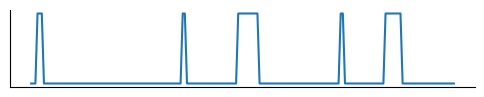

In [283]:
a = [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]
plt.figure(figsize=(6,1))
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([])

#plt.ylabel(f"k = {k}", rotation=90)
plt.plot(a);
plt.xticks([])
plt.show()


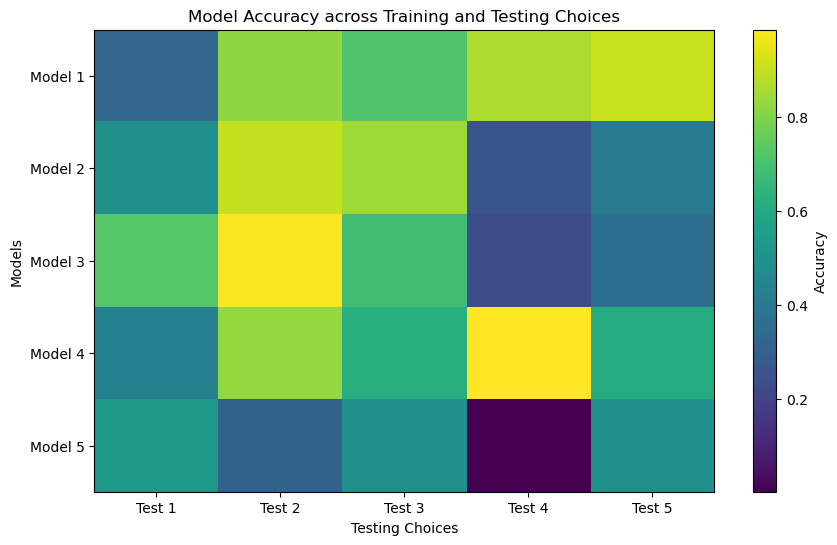

In [146]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy data (random accuracy values between 0 and 1)
num_models = 5
num_choices = 5

# Generating random accuracy values
accuracy_data = np.random.rand(num_models, num_choices)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(accuracy_data, cmap='viridis', aspect='auto')

# Adding color bar
cbar = plt.colorbar()
cbar.set_label('Accuracy')

# Adding labels
plt.title('Model Accuracy across Training and Testing Choices')
plt.xlabel('Testing Choices')
plt.ylabel('Models')
plt.xticks(np.arange(num_choices), ['Test ' + str(i+1) for i in range(num_choices)])
plt.yticks(np.arange(num_models), ['Model ' + str(i+1) for i in range(num_models)])

# Display the plot
plt.show()


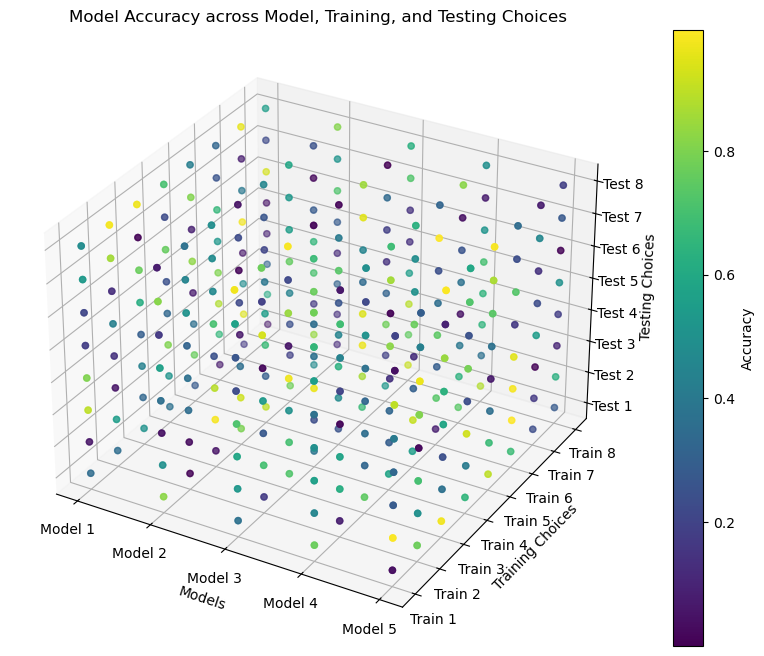

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dummy data (random accuracy values between 0 and 1)
num_models = 5
num_train_choices = 8
num_test_choices = 8

# Generating random accuracy values
accuracy_data = np.random.rand(num_models, num_train_choices, num_test_choices)

# Create meshgrid for x, y, and z coordinates
x = np.arange(num_models)
y = np.arange(num_train_choices)
z = np.arange(num_test_choices)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Plotting the 3D heatmap
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Flatten the accuracy data for plotting
accuracy_flattened = accuracy_data.flatten()

# Plotting the voxels
ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=accuracy_flattened, cmap='viridis')

# Adding color bar
cbar = plt.colorbar(ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=accuracy_flattened, cmap='viridis'))
cbar.set_label('Accuracy')

# Adding labels
ax.set_title('Model Accuracy across Model, Training, and Testing Choices')
ax.set_xlabel('Models')
ax.set_ylabel('Training Choices')
ax.set_zlabel('Testing Choices')
ax.set_xticks(np.arange(num_models))
ax.set_xticklabels(['Model ' + str(i+1) for i in range(num_models)])
ax.set_yticks(np.arange(num_train_choices))
ax.set_yticklabels(['Train ' + str(i+1) for i in range(num_train_choices)])
ax.set_zticks(np.arange(num_test_choices))
ax.set_zticklabels(['Test ' + str(i+1) for i in range(num_test_choices)])

# Display the plot
plt.show()


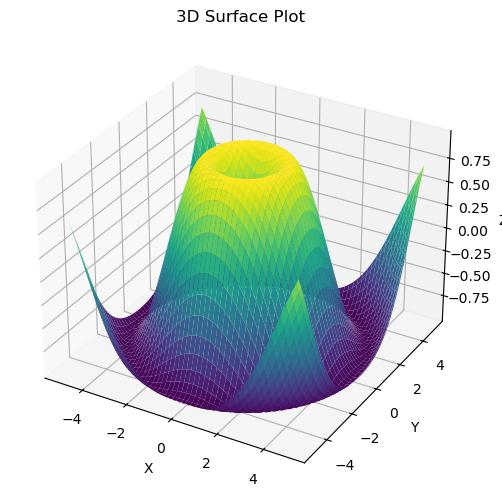

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate data
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
z = np.sin(np.sqrt(x**2 + y**2))

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Adding labels
ax.set_title('3D Surface Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the plot
plt.show()
